More work evaluating quality of topics and identifying potential sources of errors and possible avenues for improvement.

### Import packages

In [12]:
import os
import glob
import zipfile
import shutil
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
import scipy.stats as stats
import datetime
import pylab as pl
import math
import codecs
import nltk
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import time
import json
import gensim
from gensim import corpora, models
from gensim.matutils import hellinger
from gensim.models.coherencemodel import CoherenceModel
import logging
%matplotlib inline

### Set all important file paths

In [13]:
pwd()

u'/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project'

In [14]:
# Richard path specs

# # At work:
# TEXT_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/Text/"
# PDF_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/PDF/"
# LIBRARY_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/Libraries/"

# # At home:
# dict_path = '/Users/Richard/Desktop/Berkeley/w266/'
# input_path = '/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/'
# output_path = '/Users/Richard/Desktop/Berkeley/w266/'

# LIBRARY_PATH = '/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/'



In [15]:
# Tom path specs

# Tom machine:
TEXT_DIR_LIST = ["T1", "T2", "T3", "T4"]
# PDF_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/PDF/"
LIBRARY_PATH = "/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/"

# On Tom's google cloud instance
# LIBRARY_PATH = "/home/seddon/w266_project/"



In [16]:
model_spec = {"model_directory": "saved_models/topic20_minlength20_base",
              "qa_pair_directory": "saved_models/standard_preproc",
              "preprocessing_function": "testLDA_pre_process_document",
              "min_sequence_length": 20,
              "num_topics": 20,
              "description": "test model"}

In [17]:
class Saved_state():
    '''Represents a saved state that includes an LDA model and the data used to create it.
    
       Instantiated with a model_spec dictionary that locates the files to 
       recreate the saved state and includes a description.
       
       Dictionary needs to contain:
       
       model_files
       qa_pairs_file
       raw_qa_text_file
       corpus_file
       hellinger_file
       '''
    def __init__(self, model_spec):
        
        model_dir = LIBRARY_PATH+model_spec["model_directory"]
        qa_dir = LIBRARY_PATH+model_spec["qa_pair_directory"]
        
        self.ldamodel = gensim.models.ldamodel.LdaModel.load(model_dir+"/full_model")
        
        self.dictionary = gensim.corpora.dictionary.Dictionary.load(model_dir+"/dictionary.txt")
        
        with open(qa_dir+"/qa_pairs.txt", "r") as f:
            self.qa_pairs = json.loads(f.read())
            
        with open(LIBRARY_PATH + "/raw_qa_data.txt", "r") as f:
            self.raw_qa_text = json.loads(f.read())
            
        with open(model_dir+"/corpus.txt", "r") as f:
            self.corpus = json.loads(f.read())
            
        with open(model_dir+"/hell_sims.txt", "r") as f:
            self.hellinger_sims = json.loads(f.read())
            
        with open(model_dir+"/model_runtime.txt", "r") as f:
            self.model_runtime = f.read()

In [18]:
saved = Saved_state(model_spec)

In [19]:
# Restoring saved state

ldamodel = saved.ldamodel
qa_pairs= saved.qa_pairs
raw_qa_text = saved.raw_qa_text
corpus = saved.corpus
hellinger_sims = saved.hellinger_sims
dictionary = saved.dictionary
model_runtime = saved.model_runtime

print "Restored", model_spec["description"], "originally run at", model_runtime

Restored test model originally run at 2017-12-09 22:12:32.176898


## Looking at words that appear in multiple topics

Inspecting our topics, we have a number of words that appear in multiple topics, like 'think'.  These may not be helping with the distinctiveness of each topic, and may be getting learned because of our short document lengths.

In [20]:
def get_topic_counts(model_spec, topn):
    '''Retrieves saved model from a model spec.  Returns a dict containing
       how many of the topics each word that is in the top n of at least one topic
       shows up in the top n for a topic.
       
       Helps identify words that may be uninformative for topic modelling.'''
    
    topic_words = dict()
    topic_count = defaultdict(int)
    
    saved = Saved_state(model_spec)

    ldamodel = saved.ldamodel

    for n in range(model_spec["num_topics"]):
        
        topic_words[n] = ldamodel.show_topic(n, topn = topn)

    for topic in topic_words:
        for w in topic_words[topic]:
            topic_count[w[0]] += 1
            
    return topic_count
#     return topic_words

In [21]:
word_counts = get_topic_counts(model_spec, 50)

In [22]:
multi_counts = [(w, word_counts[w]) for w in word_counts if word_counts[w] > 1]
sorted_multi_counts = sorted(multi_counts, key = lambda w: w[1], reverse = True)
sorted_multi_counts

[(u'see', 12),
 (u'look', 11),
 (u'go', 10),
 (u'new', 10),
 (u'think', 10),
 (u'come', 10),
 (u'one', 9),
 (u'us', 9),
 (u'well', 8),
 (u'want', 7),
 (u'realli', 7),
 (u'year', 7),
 (u'take', 7),
 (u'busi', 7),
 (u'get', 7),
 (u'product', 7),
 (u'actual', 7),
 (u'good', 6),
 (u'term', 6),
 (u'continu', 6),
 (u'expect', 6),
 (u'first', 6),
 (u'point', 6),
 (u'like', 6),
 (u'rate', 5),
 (u'two', 5),
 (u'move', 5),
 (u'side', 5),
 (u'NUM', 5),
 (u'lot', 5),
 (u'plan', 5),
 (u'impact', 5),
 (u'make', 5),
 (u'also', 5),
 (u'know', 5),
 (u'back', 5),
 (u'growth', 5),
 (u'question', 5),
 (u'way', 5),
 (u'time', 5),
 (u'consum', 4),
 (u'higher', 4),
 (u'work', 4),
 (u'basi', 4),
 (u'talk', 4),
 (u'increas', 4),
 (u'said', 4),
 (u'last', 4),
 (u'improv', 4),
 (u'much', 4),
 (u'right', 4),
 (u'market', 4),
 (u'opportun', 4),
 (u'start', 4),
 (u'level', 3),
 (u'cost', 3),
 (u'gener', 3),
 (u'great', 3),
 (u'chang', 3),
 (u'use', 3),
 (u'obvious', 3),
 (u'give', 3),
 (u'end', 3),
 (u'grow', 3),
 

## Evaluating topic distributions

LDA should be concentrating topic probabilities for each document into a relatively small number of topics.  Want to inspect to see how true that is.

Note that Gensim cuts off topics below 0.01 in the list returned.  We can check what that's doing further below.

In [23]:
def get_topic_dists(model_spec):
    '''Perform inference to calc topic distibutions for a model
       on our dataset.
       
       Return a dictionary of topic distributions, keyed by (file_id, qnum, q/a)
       tuples.'''

    topic_dists = defaultdict(dict)
    
    model_dir = LIBRARY_PATH+model_spec["model_directory"]
    qa_dir = LIBRARY_PATH+model_spec["qa_pair_directory"]
    
    with open(qa_dir+"/qa_pairs.txt", "r") as f:
        qa_pairs = json.loads(f.read())
        
    ldamodel = gensim.models.ldamodel.LdaModel.load(model_dir+"/full_model")
    dictionary = gensim.corpora.dictionary.Dictionary.load(model_dir+"/dictionary.txt")
    
    
    print "starting"
    start_time = time.time()
    i = 0
    report_every = 10000
    
    min_sequence_length = model_spec["min_sequence_length"]

    for file_id in qa_pairs:
        for q_number in qa_pairs[file_id]:
            question, answer = qa_pairs[file_id][q_number]
            if (len(question) > min_sequence_length and
                len(answer) > min_sequence_length):
                q_bow = dictionary.doc2bow(question)
                a_bow = dictionary.doc2bow(answer)
                topic_dists[file_id+"_"+q_number+"_"+"q"] = ldamodel[q_bow]
                topic_dists[file_id+"_"+q_number+"_"+"a"] = ldamodel[a_bow]             
            i += 1
            if i % report_every == 0:
                print "Processed ", i, "pairs in", time.time() - start_time
    print "Finished in", time.time() - start_time
    
        
    return topic_dists

In [24]:
topic_dists = get_topic_dists(model_spec)

starting
Processed  10000 pairs in 11.9248490334
Processed  20000 pairs in 23.9757089615
Processed  30000 pairs in 36.1571619511
Processed  40000 pairs in 48.1233608723
Processed  50000 pairs in 60.3914990425
Processed  60000 pairs in 72.7442100048
Processed  70000 pairs in 84.2657399178
Processed  80000 pairs in 97.2280819416
Finished in 102.852529049


In [25]:
def calc_topic_scores(topic_dists):
    '''Build a dictionary of stats about the topic probs in
       a dict of a distribution of topics.
       
       Return a dict of scores for each item in the original dict'''

    topic_scores = defaultdict(dict)

    for t in topic_dists.keys():

        assigned_topics = sorted(topic_dists[t], key = lambda x: x[1], reverse = True)
        num_topics = len(assigned_topics)
        max_prob = assigned_topics[0][1]
        min_prob = assigned_topics[-1][1]
        sum_prob = max_prob
        cum_prob = dict()
        cum_prob[0] = max_prob
        for i in range(1, num_topics):
            cum_prob[i] = cum_prob[i-1] + assigned_topics[i][1]
            sum_prob += assigned_topics[i][1]

        topic_scores[t]["max_prob"] = max_prob
        topic_scores[t]["min_prob"] = min_prob
        topic_scores[t]["sum_prob"] = sum_prob
        topic_scores[t]["cum_prob"] = cum_prob
        topic_scores[t]["num_topics"] = num_topics
        
    return topic_scores


topic_scores = calc_topic_scores(topic_dists)

## Visualize the topic scores

#### Number of topics

Mean Number of topics a doc is assigned to 6.51885856745
SD Number of topics a doc is assigned to 2.13088214664


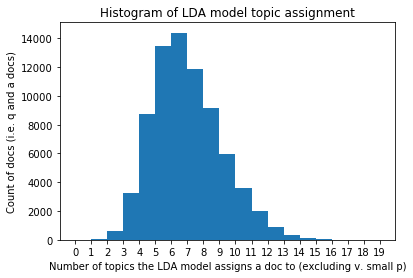

In [26]:
def histo_num_topics(topic_scores):
    n_topics = [topic_scores[t]["num_topics"] for t in topic_scores]
    print "Mean Number of topics a doc is assigned to", np.mean(n_topics)
    print "SD Number of topics a doc is assigned to", np.std(n_topics)

    plt.hist(n_topics, bins = range(20))
    plt.xlabel("Number of topics the LDA model assigns a doc to (excluding v. small p)")
    plt.ylabel("Count of docs (i.e. q and a docs)")
    plt.title("Histogram of LDA model topic assignment")
    plt.xticks(range(20))
    plt.show()
    
histo_num_topics(topic_scores)

#### Probability of highest topic

Mean of highest probability for a topic that a doc is assigned to 0.4002490142
SD of highest probability 0.12213257903


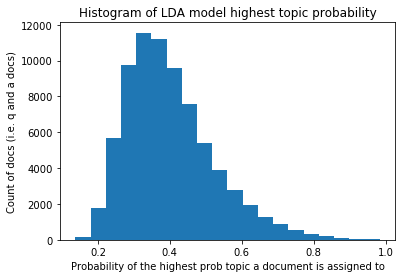

In [27]:
def histo_max_prob(topic_scores):
    max_probs = [topic_scores[t]["max_prob"] for t in topic_scores]
    print "Mean of highest probability for a topic that a doc is assigned to", np.mean(max_probs)
    print "SD of highest probability", np.std(max_probs)

    plt.hist(max_probs, bins = 20)
    plt.xlabel("Probability of the highest prob topic a document is assigned to")
    plt.ylabel("Count of docs (i.e. q and a docs)")
    plt.title("Histogram of LDA model highest topic probability")
    plt.show()
    
histo_max_prob(topic_scores)

#### Buildup of probability across topics

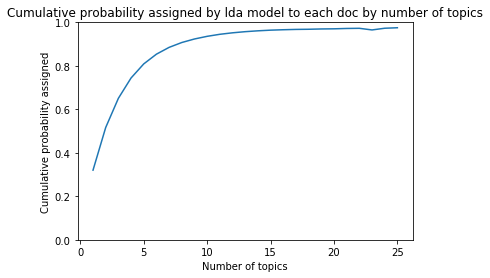

In [72]:
def chart_cum_prob(topic_scores):
    all_cums = defaultdict(int)
    total = defaultdict(int)
    for t in topic_scores.keys():
        for n in topic_scores[t]["cum_prob"]:
            all_cums[n] += topic_scores[t]["cum_prob"][n]
            total[n] += 1

    all_cums = [all_cums[n]/total[n] for n in sorted(all_cums.keys())]
    all_cums

    plt.plot(range(1, len(all_cums) +1), all_cums)

    plt.xlabel("Number of topics")
    plt.ylabel("Cumulative probability assigned")
    plt.title("Cumulative probability assigned by lda model to each doc by number of topics")
    plt.ylim([0, 1])
    plt.show()
    
chart_cum_prob(topic_scores)


#### Probability of lowest topic

Mean of lowest probability for a topic that a doc is assigned to 0.0449204144809
SD of highest probability 0.0467176149419


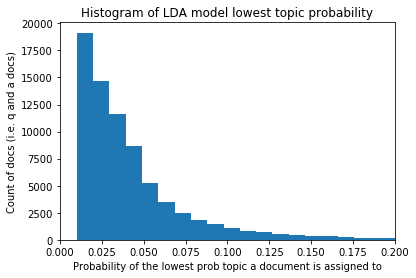

In [29]:
def histo_min_prob(topic_scores):
    min_probs = [topic_scores[t]["min_prob"] for t in topic_scores]
    print "Mean of lowest probability for a topic that a doc is assigned to", np.mean(min_probs)
    print "SD of highest probability", np.std(min_probs)

    plt.hist(min_probs, bins = 100)
    plt.xlabel("Probability of the lowest prob topic a document is assigned to")
    plt.ylabel("Count of docs (i.e. q and a docs)")
    plt.title("Histogram of LDA model lowest topic probability")
    plt.xlim([0,0.2])
    plt.show()
    
histo_min_prob(topic_scores)

#### Probability of all topics scored

Recall that gensim cuts off any below 0.1, so this gives us another check that everything is working as we expect, and also an ability to see if many topics have a lot of mass across low probaility topics.

Mean of highest probability for a topic that a doc is assigned to 0.983762585193
SD of highest probability 0.00847262065545


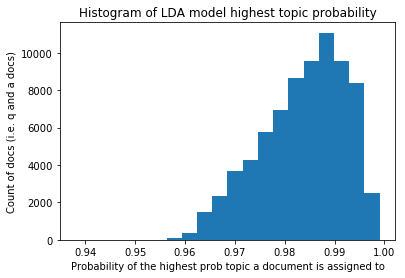

In [30]:
def histo_sum_probs(topic_scores):
    sum_probs = [topic_scores[t]["sum_prob"] for t in topic_scores]
    print "Mean of highest probability for a topic that a doc is assigned to", np.mean(sum_probs)
    print "SD of highest probability", np.std(sum_probs)

    plt.hist(sum_probs, bins = 20)
    plt.xlabel("Probability of the highest prob topic a document is assigned to")
    plt.ylabel("Count of docs (i.e. q and a docs)")
    plt.title("Histogram of LDA model highest topic probability")
    plt.show()
    
histo_sum_probs(topic_scores)

## Comparing topic distributions across the models we have

In [74]:
# First wave of models
# model_dir_list = ["topic10_minlength10_base", "topic10_minlength20_base", "topic10_minlength40_base",
#                   "topic20_minlength10_base", "topic20_minlength20_base", "topic20_minlength40_base",
#                   "topic40_minlength10_base", "topic40_minlength20_base", "topic40_minlength40_base",
#                   "topic100_minlength20_base", "topic20_minlength20_base_20passes"]

# Second wave of models
model_dir_list = ["top10_len10_prebase_ps20_it100", "top10_len20_prebase_ps20_it100",
                  "top10_len40_prebase_ps20_it100", "top20_len10_prebase_ps20_it100",
                  "top20_len20_prebase_ps20_it100", "top20_len40_prebase_ps20_it100",
                  "top40_len10_prebase_ps20_it100", "top40_len20_prebase_ps20_it100",
                  "top40_len40_prebase_ps20_it100"]

spec_list = dict()
topic_scores = dict()
        
for model_dir in model_dir_list:
    
    print "working on", model_dir
    
    with open(LIBRARY_PATH+"saved_models/"+model_dir+"/model_spec.txt") as f:
        spec_list[model_dir] = json.loads(f.read())
        
    topic_dists = get_topic_dists(spec_list[model_dir])
    
    # Write out to file to save having to run everything to access them again
    with open(LIBRARY_PATH+"saved_models/"+model_dir+"/topic_dists.txt", "w") as f:
        f.write(json.dumps(topic_dists))
    
    topic_scores[model_dir] = calc_topic_scores(topic_dists)
    
    with open(LIBRARY_PATH+"saved_models/"+model_dir+"/topic_scores.txt", "w") as f:
        f.write(json.dumps(topic_scores))


working on top10_len10_prebase_ps20_it100
starting
Processed  10000 pairs in 13.2757530212
Processed  20000 pairs in 27.1214859486
Processed  30000 pairs in 41.5503628254
Processed  40000 pairs in 54.5069019794
Processed  50000 pairs in 67.6510128975
Processed  60000 pairs in 80.5837688446
Processed  70000 pairs in 93.1270639896
Processed  80000 pairs in 106.858386993
Finished in 113.054535866
working on top10_len20_prebase_ps20_it100
starting
Processed  10000 pairs in 11.9110760689
Processed  20000 pairs in 22.785733223
Processed  30000 pairs in 33.8648650646
Processed  40000 pairs in 44.8983540535
Processed  50000 pairs in 55.9020261765
Processed  60000 pairs in 68.25791502
Processed  70000 pairs in 80.7167410851
Processed  80000 pairs in 92.4730160236
Finished in 98.5261650085
working on top10_len40_prebase_ps20_it100
starting
Processed  10000 pairs in 4.95903110504
Processed  20000 pairs in 9.23437404633
Processed  30000 pairs in 13.4543421268
Processed  40000 pairs in 17.709055900

In [75]:
# Reload from saved distributions
# The topic dist is the slow step, so just recalculating topic scores here

def load_topic_dists(model_dir_list):
    '''return topic dists for all the models in the list'''
    
    topic_dist_dict = dict()
    for model_dir in model_dir_list:
        with open(LIBRARY_PATH+"saved_models/"+model_dir+"/topic_dists.txt") as f:
            topic_dist_dict[model_dir] = json.loads(f.read())
            
    return topic_dist_dict

spec_list = dict()
topic_scores = dict()

topic_dist_dict = load_topic_dists(model_dir_list)

for model_dir in topic_dist_dict:
    topic_scores[model_dir] = calc_topic_scores(topic_dist_dict[model_dir])
    
    with open(LIBRARY_PATH+"saved_models/"+model_dir+"/model_spec.txt") as f:
        spec_list[model_dir] = json.loads(f.read())

top40_len20_prebase_ps20_it100
Topics 40, Min Length 20, base preprocessing, passes20, iterations100

Mean Number of topics a doc is assigned to 9.9099426335
SD Number of topics a doc is assigned to 3.14939577805


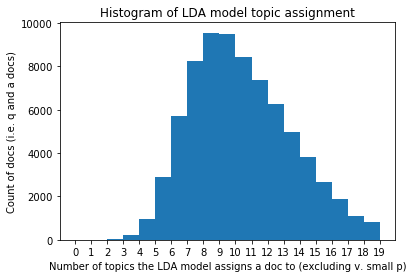

top10_len40_prebase_ps20_it100
Topics 10, Min Length 40, base preprocessing, passes20, iterations100

Mean Number of topics a doc is assigned to 4.81090977727
SD Number of topics a doc is assigned to 1.38707084786


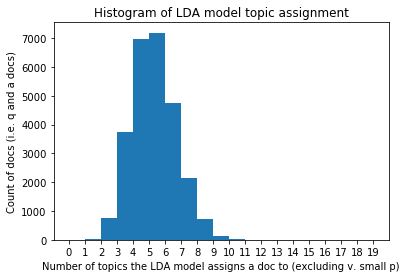

top20_len20_prebase_ps20_it100
Topics 20, Min Length 20, base preprocessing, passes20, iterations100

Mean Number of topics a doc is assigned to 6.66022410465
SD Number of topics a doc is assigned to 2.10584277342


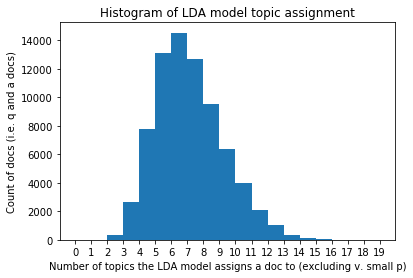

top10_len10_prebase_ps20_it100
Topics 10, Min Length 10, base preprocessing, passes20, iterations100

Mean Number of topics a doc is assigned to 4.58145460314
SD Number of topics a doc is assigned to 1.50812993528


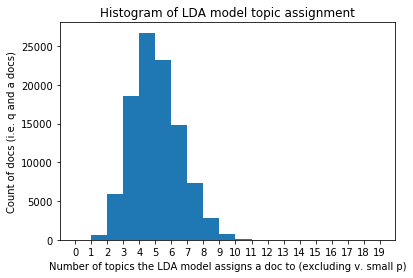

top40_len40_prebase_ps20_it100
Topics 40, Min Length 40, base preprocessing, passes20, iterations100

Mean Number of topics a doc is assigned to 9.07731219328
SD Number of topics a doc is assigned to 2.51052645805


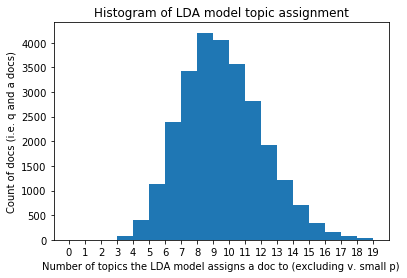

top20_len10_prebase_ps20_it100
Topics 20, Min Length 10, base preprocessing, passes20, iterations100

Mean Number of topics a doc is assigned to 6.4530466163
SD Number of topics a doc is assigned to 2.32886087446


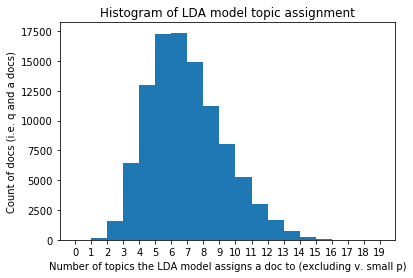

top40_len10_prebase_ps20_it100
Topics 40, Min Length 10, base preprocessing, passes20, iterations100

Mean Number of topics a doc is assigned to 9.36803283564
SD Number of topics a doc is assigned to 3.42268446568


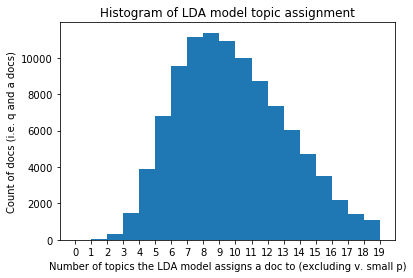

top10_len20_prebase_ps20_it100
Topics 10, Min Length 20, base preprocessing, passes20, iterations100

Mean Number of topics a doc is assigned to 4.67691132318
SD Number of topics a doc is assigned to 1.42990180624


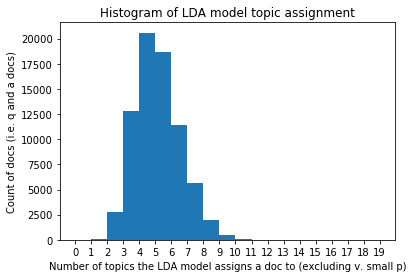

top20_len40_prebase_ps20_it100
Topics 20, Min Length 40, base preprocessing, passes20, iterations100

Mean Number of topics a doc is assigned to 6.74416761042
SD Number of topics a doc is assigned to 1.96039710517


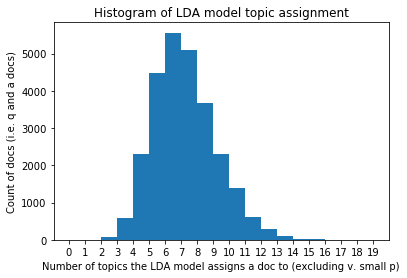

In [76]:
for m in topic_scores:
    print m
    print spec_list[m]["description"]
    print
    histo_num_topics(topic_scores[m])


Topics 40, Min Length 20, base preprocessing, passes20, iterations100

Mean of highest probability for a topic that a doc is assigned to 0.306415921844
SD of highest probability 0.0959457856957


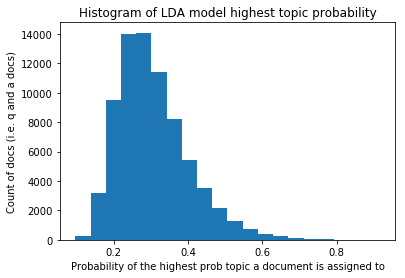


Topics 10, Min Length 40, base preprocessing, passes20, iterations100

Mean of highest probability for a topic that a doc is assigned to 0.454309714022
SD of highest probability 0.132118501641


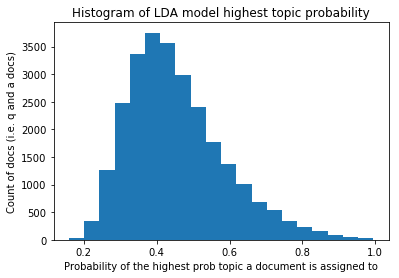


Topics 20, Min Length 20, base preprocessing, passes20, iterations100

Mean of highest probability for a topic that a doc is assigned to 0.380657555804
SD of highest probability 0.113753408478


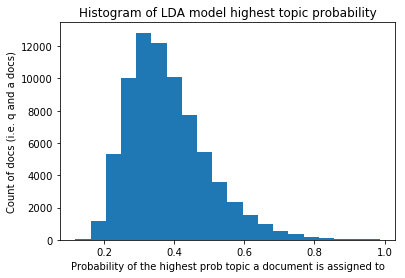


Topics 10, Min Length 10, base preprocessing, passes20, iterations100

Mean of highest probability for a topic that a doc is assigned to 0.463885072259
SD of highest probability 0.13527021414


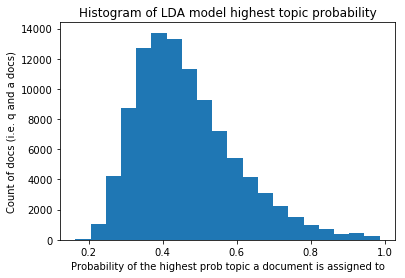


Topics 40, Min Length 40, base preprocessing, passes20, iterations100

Mean of highest probability for a topic that a doc is assigned to 0.363815161405
SD of highest probability 0.105846217871


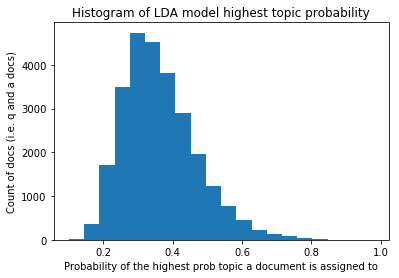


Topics 20, Min Length 10, base preprocessing, passes20, iterations100

Mean of highest probability for a topic that a doc is assigned to 0.385182670521
SD of highest probability 0.120364585843


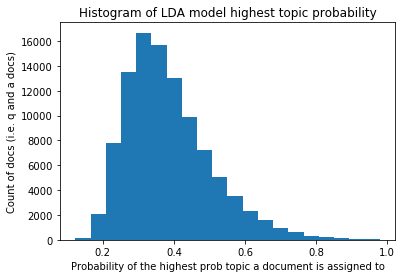


Topics 40, Min Length 10, base preprocessing, passes20, iterations100

Mean of highest probability for a topic that a doc is assigned to 0.319916301339
SD of highest probability 0.108124833153


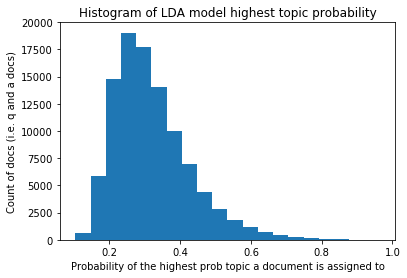


Topics 10, Min Length 20, base preprocessing, passes20, iterations100

Mean of highest probability for a topic that a doc is assigned to 0.460494444364
SD of highest probability 0.133789470441


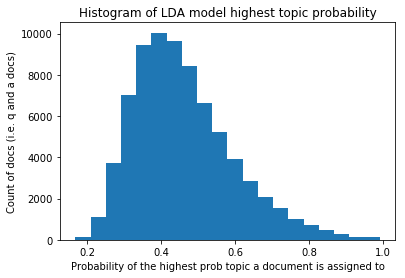


Topics 20, Min Length 40, base preprocessing, passes20, iterations100

Mean of highest probability for a topic that a doc is assigned to 0.40103004199
SD of highest probability 0.118282335653


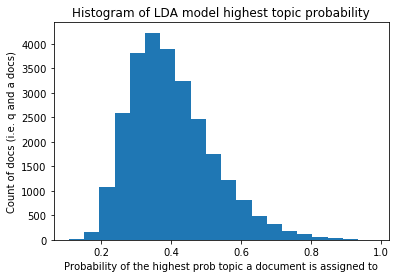

In [77]:
for m in topic_scores:
    print
    print spec_list[m]["description"]
    print
    histo_max_prob(topic_scores[m])


Topics 40, Min Length 20, base preprocessing, passes20, iterations100



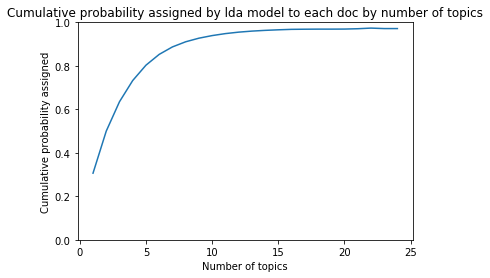


Topics 10, Min Length 40, base preprocessing, passes20, iterations100



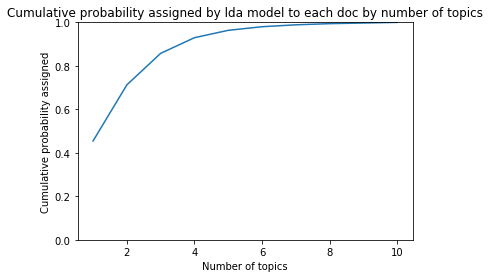


Topics 20, Min Length 20, base preprocessing, passes20, iterations100



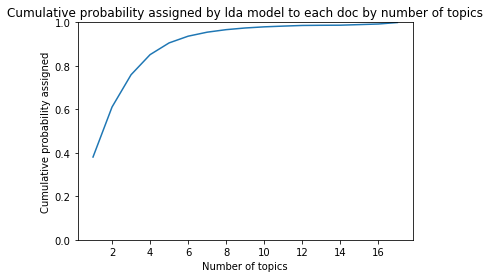


Topics 10, Min Length 10, base preprocessing, passes20, iterations100



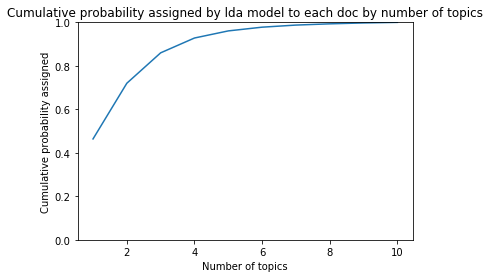


Topics 40, Min Length 40, base preprocessing, passes20, iterations100



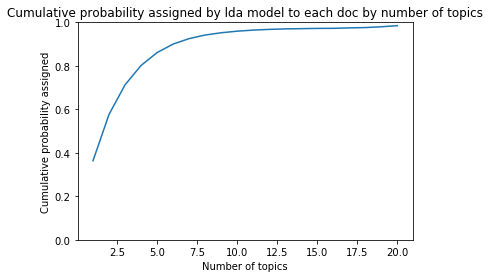


Topics 20, Min Length 10, base preprocessing, passes20, iterations100



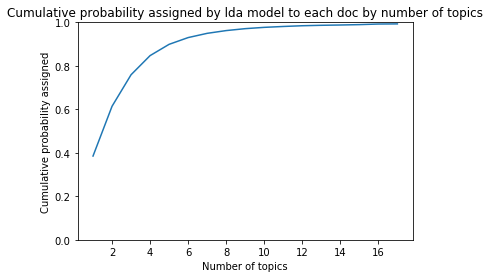


Topics 40, Min Length 10, base preprocessing, passes20, iterations100



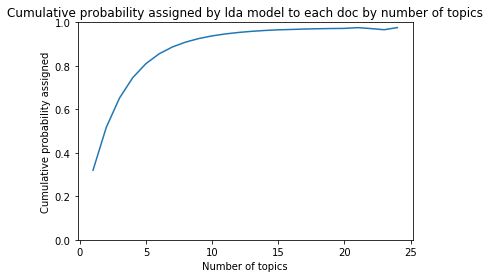


Topics 10, Min Length 20, base preprocessing, passes20, iterations100



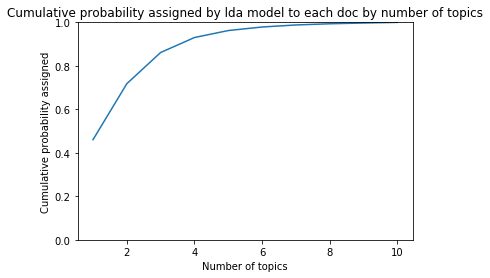


Topics 20, Min Length 40, base preprocessing, passes20, iterations100



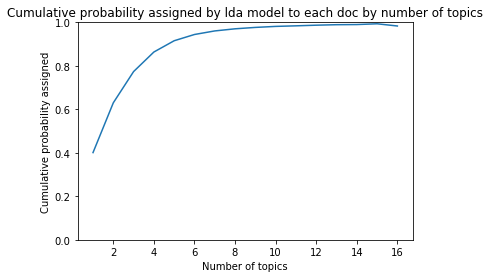

In [78]:
for m in topic_scores:
    print
    print spec_list[m]["description"]
    print
    chart_cum_prob(topic_scores[m])


Topics 40, Min Length 20, base preprocessing, passes20, iterations100

Mean of lowest probability for a topic that a doc is assigned to 0.0271517644097
SD of highest probability 0.0184616948159


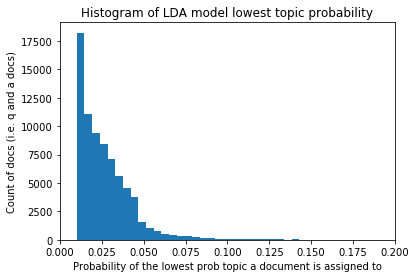


Topics 10, Min Length 40, base preprocessing, passes20, iterations100

Mean of lowest probability for a topic that a doc is assigned to 0.0737367574209
SD of highest probability 0.0726239810729


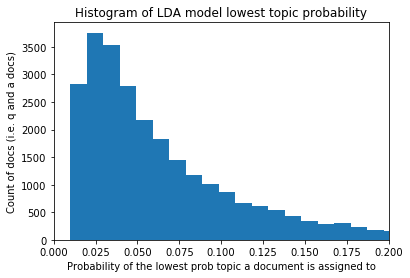


Topics 20, Min Length 20, base preprocessing, passes20, iterations100

Mean of lowest probability for a topic that a doc is assigned to 0.0446510137873
SD of highest probability 0.0432958744706


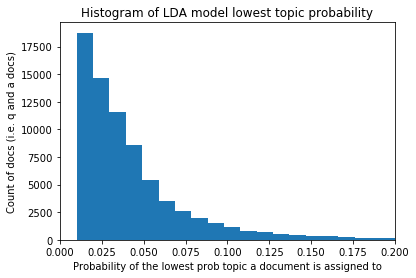


Topics 10, Min Length 10, base preprocessing, passes20, iterations100

Mean of lowest probability for a topic that a doc is assigned to 0.0948745876644
SD of highest probability 0.102098811542


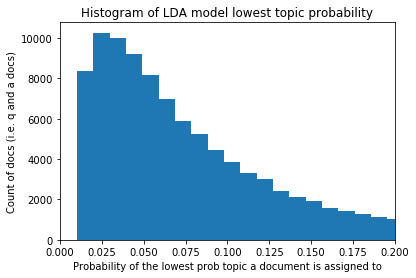


Topics 40, Min Length 40, base preprocessing, passes20, iterations100

Mean of lowest probability for a topic that a doc is assigned to 0.020811043319
SD of highest probability 0.0160265895459


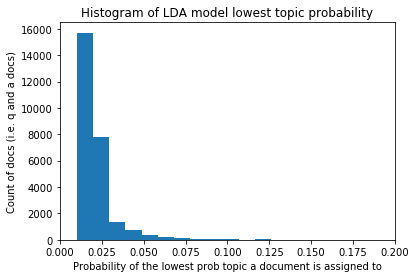


Topics 20, Min Length 10, base preprocessing, passes20, iterations100

Mean of lowest probability for a topic that a doc is assigned to 0.0561143187281
SD of highest probability 0.0626502266817


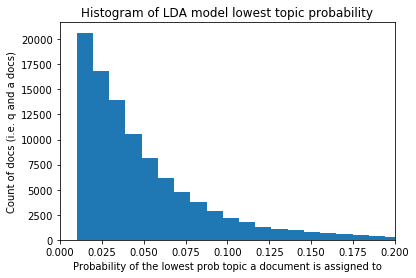


Topics 40, Min Length 10, base preprocessing, passes20, iterations100

Mean of lowest probability for a topic that a doc is assigned to 0.0343210851981
SD of highest probability 0.0332644854175


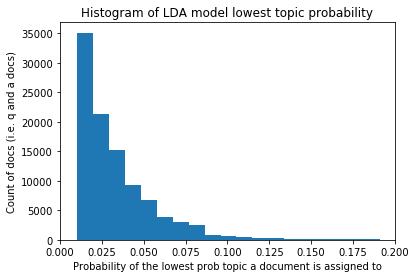


Topics 10, Min Length 20, base preprocessing, passes20, iterations100

Mean of lowest probability for a topic that a doc is assigned to 0.0828616958612
SD of highest probability 0.0825616683662


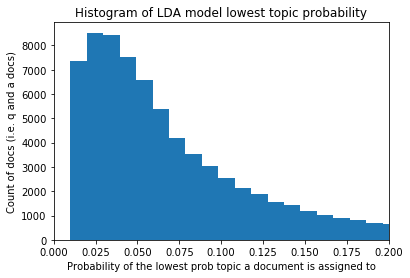


Topics 20, Min Length 40, base preprocessing, passes20, iterations100

Mean of lowest probability for a topic that a doc is assigned to 0.0370248255024
SD of highest probability 0.0347799109954


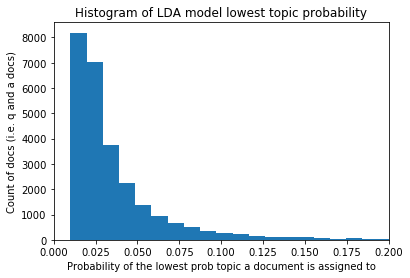

In [79]:
for m in topic_scores:
    print
    print spec_list[m]["description"]
    print
    histo_min_prob(topic_scores[m])


Topics 40, Min Length 20, base preprocessing, passes20, iterations100

Mean of highest probability for a topic that a doc is assigned to 0.980062250808
SD of highest probability 0.00971187903802


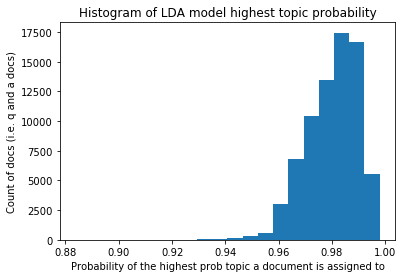


Topics 10, Min Length 40, base preprocessing, passes20, iterations100

Mean of highest probability for a topic that a doc is assigned to 0.991855055019
SD of highest probability 0.00420084786864


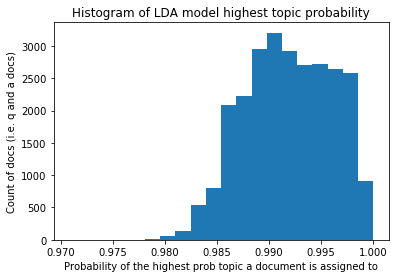


Topics 20, Min Length 20, base preprocessing, passes20, iterations100

Mean of highest probability for a topic that a doc is assigned to 0.983947436652
SD of highest probability 0.0083780697234


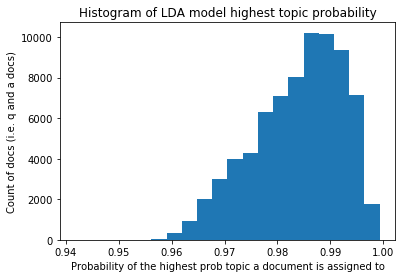


Topics 10, Min Length 10, base preprocessing, passes20, iterations100

Mean of highest probability for a topic that a doc is assigned to 0.983136226072
SD of highest probability 0.0136331284508


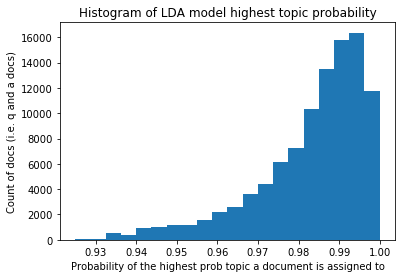


Topics 40, Min Length 40, base preprocessing, passes20, iterations100

Mean of highest probability for a topic that a doc is assigned to 0.983748092465
SD of highest probability 0.00832137960249


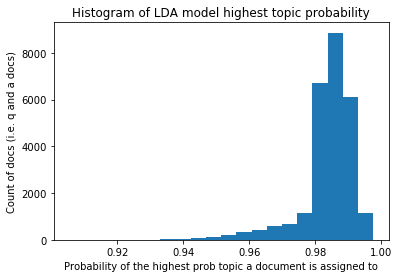


Topics 20, Min Length 10, base preprocessing, passes20, iterations100

Mean of highest probability for a topic that a doc is assigned to 0.978989162047
SD of highest probability 0.014857792609


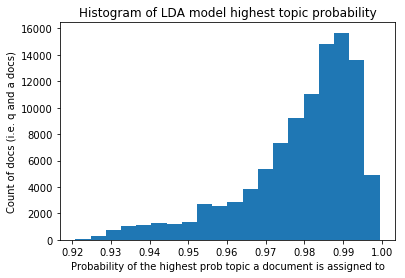


Topics 40, Min Length 10, base preprocessing, passes20, iterations100

Mean of highest probability for a topic that a doc is assigned to 0.974434567675
SD of highest probability 0.015661637904


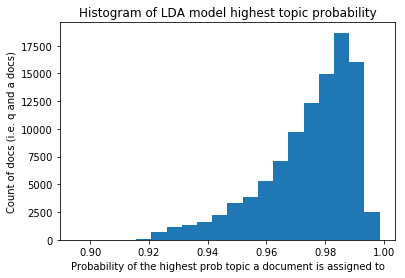


Topics 10, Min Length 20, base preprocessing, passes20, iterations100

Mean of highest probability for a topic that a doc is assigned to 0.987562213453
SD of highest probability 0.00781346756058


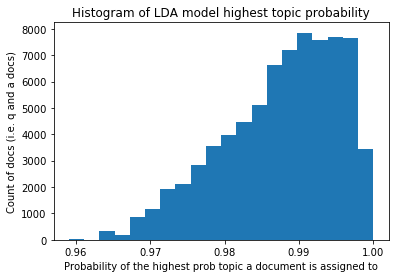


Topics 20, Min Length 40, base preprocessing, passes20, iterations100

Mean of highest probability for a topic that a doc is assigned to 0.988878614208
SD of highest probability 0.00467254263731


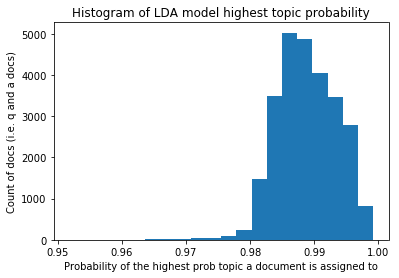

In [80]:
for m in topic_scores:
    print
    print spec_list[m]["description"]
    print
    histo_sum_probs(topic_scores[m])


Topics 20, Min Length 20, base preprocessing, passes20, iterations100

Mean Number of topics a doc is assigned to 6.79388269354
SD Number of topics a doc is assigned to 2.12951318384


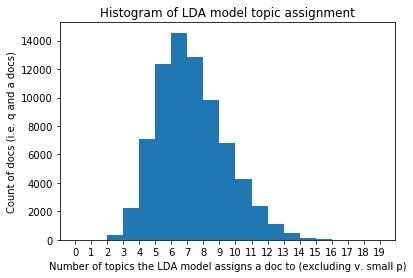

Mean of highest probability for a topic that a doc is assigned to 0.388517112076
SD of highest probability 0.115804340217


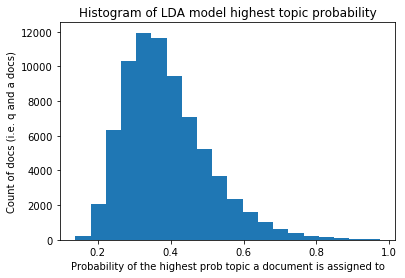

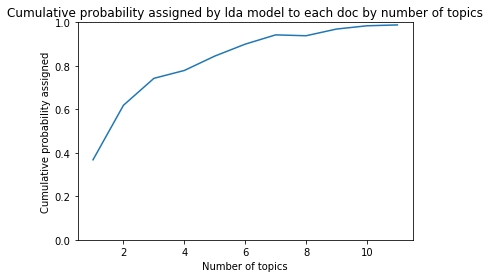

Mean of lowest probability for a topic that a doc is assigned to 0.0419039769935
SD of highest probability 0.0399554679952


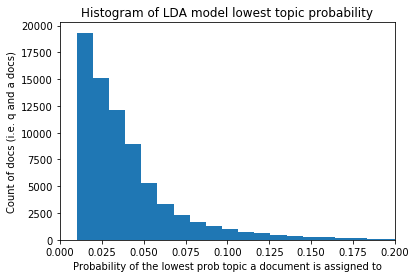

Mean of highest probability for a topic that a doc is assigned to 0.984048001688
SD of highest probability 0.008389162732


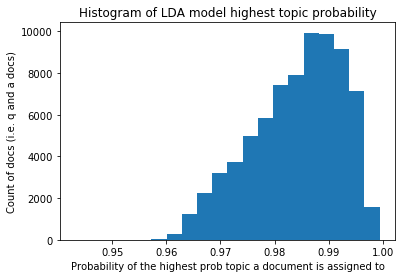

In [169]:
# for m in topic_scores:
#     print
#     print spec_list[m]["description"]
#     print
#     histo_num_topics(topic_scores[m])
#     histo_max_prob(topic_scores[m])
#     chart_cum_prob(topic_scores[m])
#     histo_min_prob(topic_scores[m])
#     histo_sum_probs(topic_scores[m])